In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.metrics import  confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, BatchNormalization, Bidirectional, Conv1D, GlobalMaxPooling1D, InputLayer
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/packt/train.csv", dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv("/content/drive/MyDrive/packt/test.csv", dtype={'id': np.int16})

print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


In [ ]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
null_table = pd.DataFrame()
null_table['null_count'] = train.isna().sum()
null_table['null_pct'] = (train.isna().sum() / train.shape[0]) / 100
null_table['data_type'] = train.dtypes
null_table.sort_values(by=['null_pct'], ascending=False, inplace=True)
null_table = null_table[null_table['null_count'] > 0]
null_table

,null_count,null_pct,data_type
location,2533,0.003327,object
keyword,61,0.000080,object


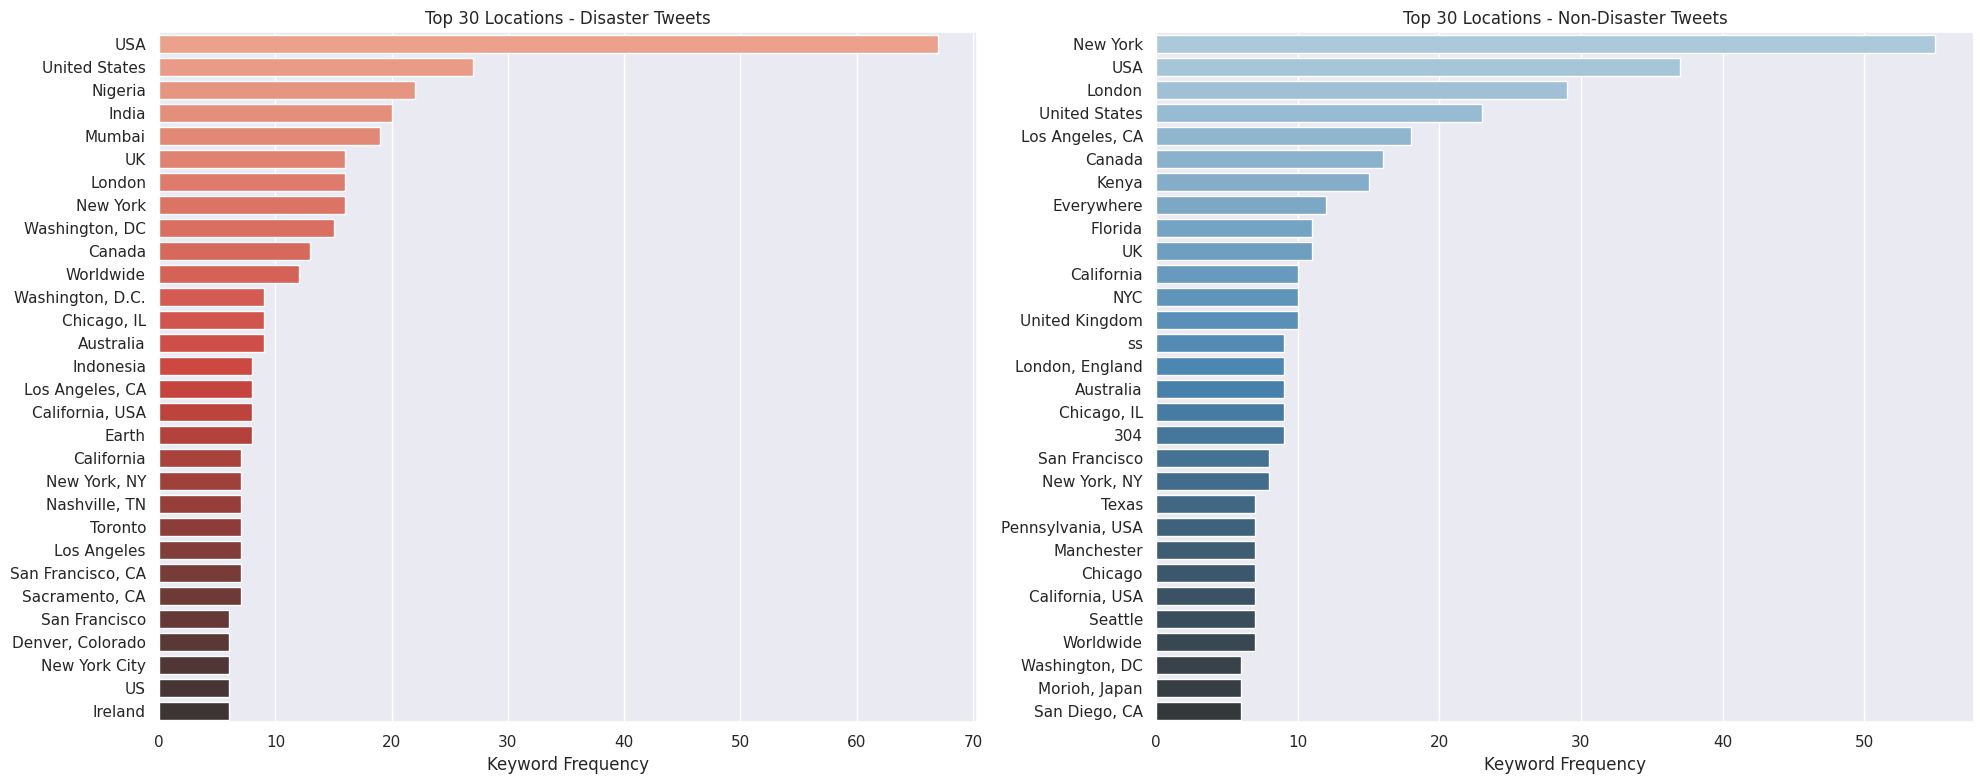

In [ ]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()
nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:30].index, x=disaster_locations[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_locations[0:30].index, x=nondisaster_locations[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()


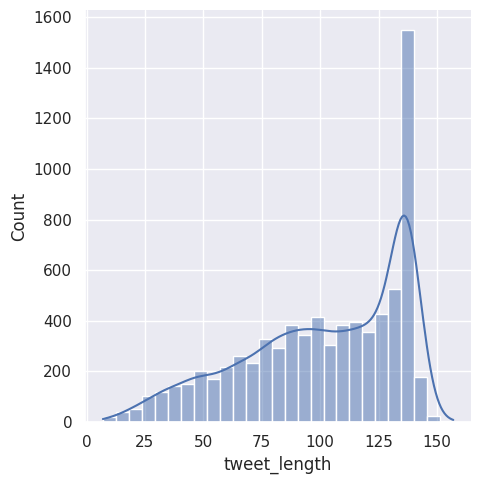

In [ ]:
train['tweet_length'] = train['text'].apply(lambda x: len(x))
sns.displot(train.tweet_length, kde=True)
plt.show()

In [ ]:
train.tweet_length.min(), train.tweet_length.max()

(7, 157)

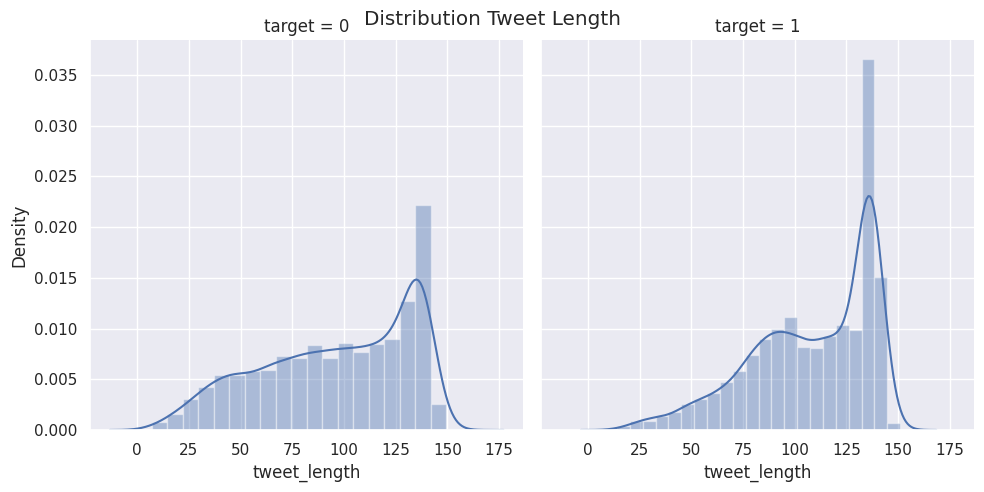

In [ ]:
g = sns.FacetGrid(train, col='target', height=5)
g = g.map(sns.distplot, 'tweet_length')
plt.suptitle("Distribution Tweet Length")
plt.show()

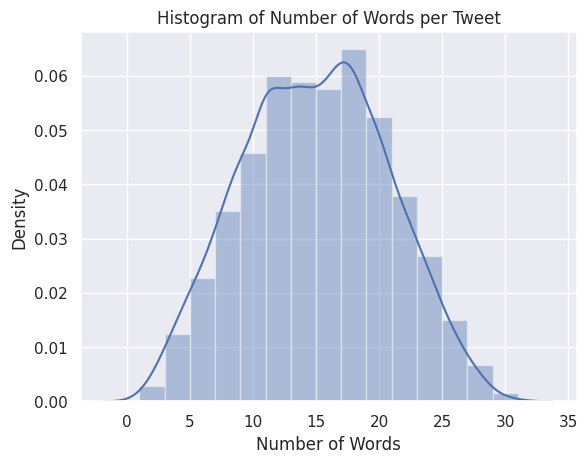

In [ ]:
def split_words(x):
    return len(x.split())

train['num_words'] = train['text'].apply(split_words)
sns.distplot(train["num_words"], bins=15)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()


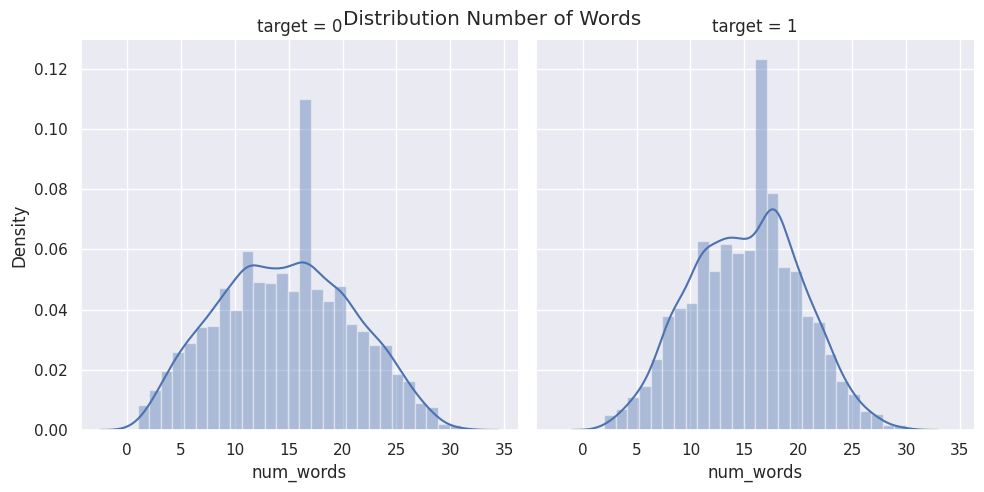

In [ ]:
g = sns.FacetGrid(train, col='target', height=5)
g = g.map(sns.distplot, 'num_words')
plt.suptitle("Distribution Number of Words")
plt.show()

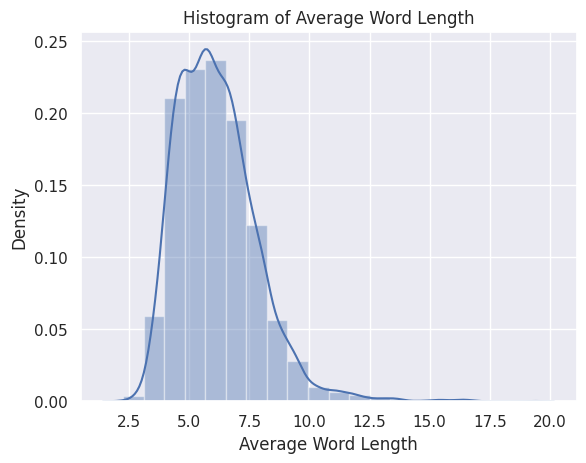

In [ ]:
def avg_word_length(x):
    return np.sum([len(i) for i in x.split()]) / len(x.split())

train['avg_word_len'] = train['text'].apply(avg_word_length)
sns.distplot(train.avg_word_len, bins=20)
plt.title('Histogram of Average Word Length')
plt.xlabel('Average Word Length')
plt.ylabel('Density')
plt.show()


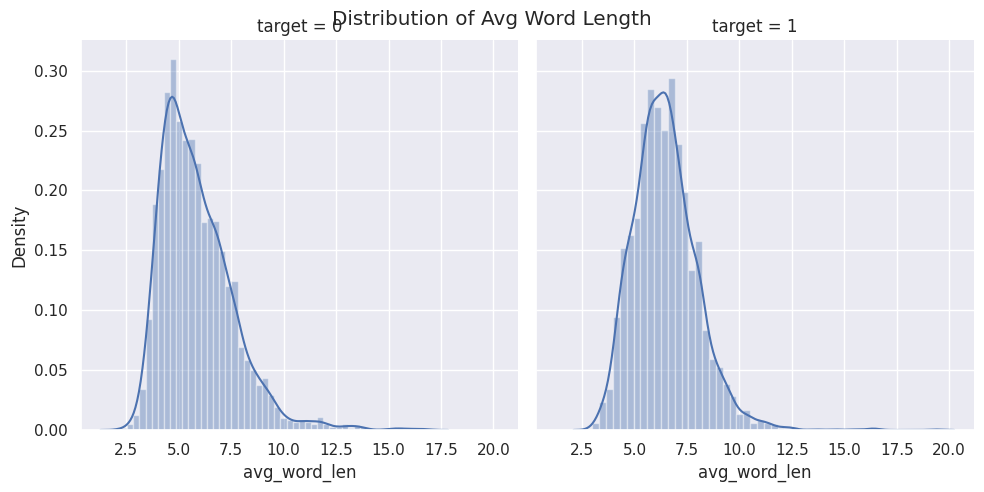

In [ ]:
g = sns.FacetGrid(train, col='target', height=5)
g = g.map(sns.distplot, 'avg_word_len')
plt.suptitle('Distribution of Avg Word Length')
plt.show()

In [ ]:
train

,id,keyword,location,text,target,tweet_length,num_words,avg_word_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11,6.636364
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,20,5.300000
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8,7.250000
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,19,6.263158


PRE-PROCESSING

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
     "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
     "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
     "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
     "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
     "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
#Replace all UPLs by "URL"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

#Remove HTML
def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

#Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

#Change an abbrevation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [ ]:
#Replace all abbrevations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

#Remove @ and mention, replace by USER
def remove_mention(text):
    at = re.compile(r'@\S+')
    return at.sub(r'USER', text)

#Remove numbers by "NUMBER"
def remove_number(text):
    num = re.compile(r'[-+]?[.\d][\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)


In [ ]:
# Remove all Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

#Replace some other smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=:]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

In [ ]:
# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)


In [ ]:
#Replace all UPLs by "URL"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

#Remove HTML
def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

#Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

#Change an abbrevation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

#Replace all abbrevations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "
    return string

#Remove @ and mention, replace by USER
def remove_mention(text):
    at = re.compile(r'@\S+')
    return at.sub(r'USER', text)

#Remove numbers by "NUMBER"
def remove_number(text):
    num = re.compile(r'[-+]?[.\d][\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

#Replace some other smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=:]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)


# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')

        text = text.replace('...', ' ... ')
        if '...' not in text:
            text = text.replace('..', ' ... ')
        return text

In [ ]:
# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [ ]:
def clean_tweet(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # Lower text, replace abbreviations
    text = text.lower()
    text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_number(text)

    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)

    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    return text

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Clean text and add a new feature
train["clean_text"] = train["text"].apply(clean_tweet)
test["clean_text"] = test["text"].apply(clean_tweet)

train["clean_tokens"] = train["clean_text"].apply(lambda x: word_tokenize(x))
test["clean_tokens"] = test["clean_text"].apply(lambda x: word_tokenize(x))

In [ ]:
train

,id,keyword,location,text,target,tweet_length,num_words,avg_word_len,clean_text,clean_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615,our deeds are the reason of this #earthquake m...,"[our, deeds, are, the, reason, of, this, #, ea..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,forest fire near la ronge sask. canada,"[forest, fire, near, la, ronge, sask, ., canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909,all residents asked to 'shelter in place' are ...,"[all, residents, asked, to, 'shelter, in, plac..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000,NUMBER people receive #wildfires evacuation or...,"[NUMBER, people, receive, #, wildfires, evacua..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000,just got sent this photo from ruby #alaska as ...,"[just, got, sent, this, photo, from, ruby, #, ..."
...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11,6.636364,two giant cranes holding a bridge collapse int...,"[two, giant, cranes, holding, a, bridge, colla..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,20,5.300000,USER USER the out of control wild fires in cal...,"[USER, USER, the, out, of, control, wild, fire..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8,7.250000,m1NUMBER [NUMBER utc]?5km s of volcano hawaii....,"[m1NUMBER, [, NUMBER, utc, ], ?, 5km, s, of, v..."
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,19,6.263158,police investigating after an e-bike collided ...,"[police, investigating, after, an, e-bike, col..."


PREPROCESS THE DATASET

In [ ]:
BATCH_SIZE = 15
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
X = train['clean_text']
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
X_test = test['clean_text']

TOKENIZE THE TEXT

In [ ]:
# Tokanize the texts
max_words = 20000
tokanizer = Tokenizer(num_words=max_words,  oov_token="<OOV>")
tokanizer.fit_on_texts(X_train)
word_index = tokanizer.word_index

# Convert text to sequence and pad them together
X_train_sequences = tokanizer.texts_to_sequences(X_train)
X_val_sequences = tokanizer.texts_to_sequences(X_val)
X_test_sequences = tokanizer.texts_to_sequences(X_test)

max_length = 35
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

CALLBACK

In [ ]:
class CustomCallback(Callback):
    def __init__(self, target_accuracy=0.90):
        super(CustomCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nReached target accuracy ({self.target_accuracy}), stopping training!")
            self.model.stop_training = True

custom_callback = CustomCallback(target_accuracy=0.90)

early_stopper = EarlyStopping(monitor='val_accuracy',
                              min_delta= 0.01,
                              patience = 7,
                              restore_best_weights=True
                             )

Building a LSTM model

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

with strategy.scope():

    model = Sequential(
        [
            Embedding(input_dim=max_words, output_dim=32, input_length=max_length),

            LSTM(60, return_sequences=True),
            Conv1D(15,kernel_size=(5)),

            Dropout(0.5),
            GlobalMaxPooling1D(),
            Dense(1, activation='sigmoid')
        ]
    )

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 32)            640000    
                                                                 
 lstm (LSTM)                 (None, 35, 60)            22320     
                                                                 
 conv1d (Conv1D)             (None, 31, 15)            4515      
                                                                 
 dropout (Dropout)           (None, 31, 15)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 15)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                        

In [ ]:
hist = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), batch_size=15 ,epochs=25 , callbacks=[custom_callback, early_stopper])

Epoch 1/25


 MODEL PERFORMANCE

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize= (22,8))
sns.lineplot(hist.history['loss'], ax= axes[0], label='loss')
sns.lineplot(hist.history['val_loss'], ax=axes[0], label='Validation loss')
axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Chart')

sns.lineplot(hist.history['accuracy'], ax=axes[1], label='Training Accuracy')
sns.lineplot(hist.history['val_accuracy'], ax=axes[1], label='Validation Accuracy')
axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Chart')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    cm = confusion_matrix(y_true, (y_pred >= 0.5).astype(int))
    f1 = f1_score(y_true, (y_pred >= 0.5).astype(int))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix on {dataset} Dataset - F1 Score: {f1:.2f}')
    plt.show()

In [ ]:
pred = model.predict(X_val_padded)
displayConfusionMatrix(y_val, pred,'Validation')